In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

!sudo apt-get install -y xvfb ffmpeg
!pip install 'xvfbwrapper==0.2.9'
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install gast

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

import abc
import base64
import imageio
import io
import IPython
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow_probability as tfp
import numpy as np
import shutil
import tempfile
import zipfile

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# TF-Agents in detail


# Environments

## Introduction

The goal of Reinforcement Learning (RL) is to design agents that learn by interacting with an environment. In the standard RL setting, the agent receives an observation at every time step and chooses an action. The action is applied to the environment and the environment returns a reward and a new observation. The agent trains a policy to choose actions to maximize the sum of rewards, also known as return.

In TF-Agents, environments can be implemented either in Python or TensorFlow. Python environments are usually easier to implement, understand, and debug, but TensorFlow environments are more efficient and allow natural parallelization. The most common workflow is to implement an environment in Python and use a wrapper to automatically convert it into TensorFlow.

Let us look at Python environments first. TensorFlow environments follow a very similar API.

## Setup


In [2]:
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

tf.compat.v1.enable_v2_behavior()

## Python Environments

Python environments have a `step(action) -> next_time_step` method that applies an action to the environment, and returns the following information about the next step:
1. `observation`: This is the part of the environment state that the agent can observe to choose its actions at the next step.
2. `reward`: The agent is learning to maximize the sum of these rewards across multiple steps.
3. `step_type`: Interactions with the environment are usually part of a sequence/episode. e.g. multiple moves in a game of chess. step_type can be either `FIRST`, `MID` or `LAST` to indicate whether this time step is the first, intermediate or last step in a sequence.
4. `discount`: This is a float representing how much to weight the reward at the next time step relative to the reward at the current time step.

These are grouped into a named tuple `TimeStep(step_type, reward, discount, observation)`.

The interface that all python environments must implement is in `environments/py_environment.PyEnvironment`. The main methods are:

In [3]:
class PyEnvironment(object):

    def reset(self):
        """Return initial_time_step."""
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        return self._current_time_step

    def time_step_spec(self):
        """Return time_step_spec."""

    @abc.abstractmethod
    def observation_spec(self):
        """Return observation_spec."""

    @abc.abstractmethod
    def action_spec(self):
        """Return action_spec."""

    @abc.abstractmethod
    def _reset(self):
        """Return initial_time_step."""

    @abc.abstractmethod
    def _step(self, action):
        """Apply action and return new time_step."""
        self._current_time_step = self._step(action)
        return self._current_time_step

In addition to the `step()` method, environments also provide a `reset()` method that starts a new sequence and provides an initial `TimeStep`. It is not necessary to call the `reset` method explicitly. We assume that environments reset automatically, either when they get to the end of an episode or when step() is called the first time.

Note that subclasses do not implement `step()` or `reset()` directly. They instead override the `_step()` and `_reset()` methods. The time steps returned from  these methods will be cached and exposed through `current_time_step()`.

The `observation_spec` and the `action_spec` methods return a nest of `(Bounded)ArraySpecs` that describe the name, shape, datatype and ranges of the observations and actions respectively.

In TF-Agents we repeatedly refer to nests which are defined as any tree like structure composed of lists, tuples, named-tuples, or dictionaries. These can be arbitrarily composed to maintain structure of observations and actions. This is very useful for more complex environments where we have many observations and actions.

### Using Standard Environments

TF Agents has built-in wrappers for many standard environments like the OpenAI Gym, DeepMind-control and Atari, so that they follow our `py_environment.PyEnvironment` interface. These wrapped environments can be easily loaded using our environment suites. Let's load the Pendulum environment from the OpenAI gym and look at the action and time_step_spec.

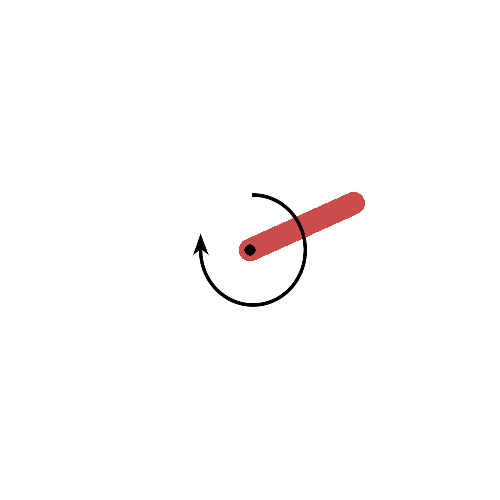

In [4]:
environment = suite_gym.load('Pendulum-v0')
environment.reset()
PIL.Image.fromarray(environment.render())

In [5]:
print('action_spec:', environment.action_spec())
print('\ntime_step_spec.observation:', environment.time_step_spec().observation)
print('\ntime_step_spec.step_type:', environment.time_step_spec().step_type)
print('\ntime_step_spec.discount:', environment.time_step_spec().discount)
print('\ntime_step_spec.reward:', environment.time_step_spec().reward)

action_spec: BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)

time_step_spec.observation: BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='observation', minimum=[-1. -1. -8.], maximum=[1. 1. 8.])

time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')

time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)

time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


So we see that the environment expects an action (Joint Effort) of type `float32` in [-2, 2.0] and returns `TimeSteps` where the observations are a `float32` vector of length 3 ($[cos(\theta),sin(\theta),\dot{\theta}]$) and discount factor is a `float32` in [0.0, 1.0]. Now, let's try to take a fixed action `(1,)` for a whole episode.

In [6]:
action = np.array([1.0], dtype=np.float32)
time_step = environment.reset()
print(time_step)
observations = []
while not time_step.is_last():
    time_step = environment.step(action)
    observations.append(time_step.observation)

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.9772505 , 0.21208814, 0.4694516 ], dtype=float32))


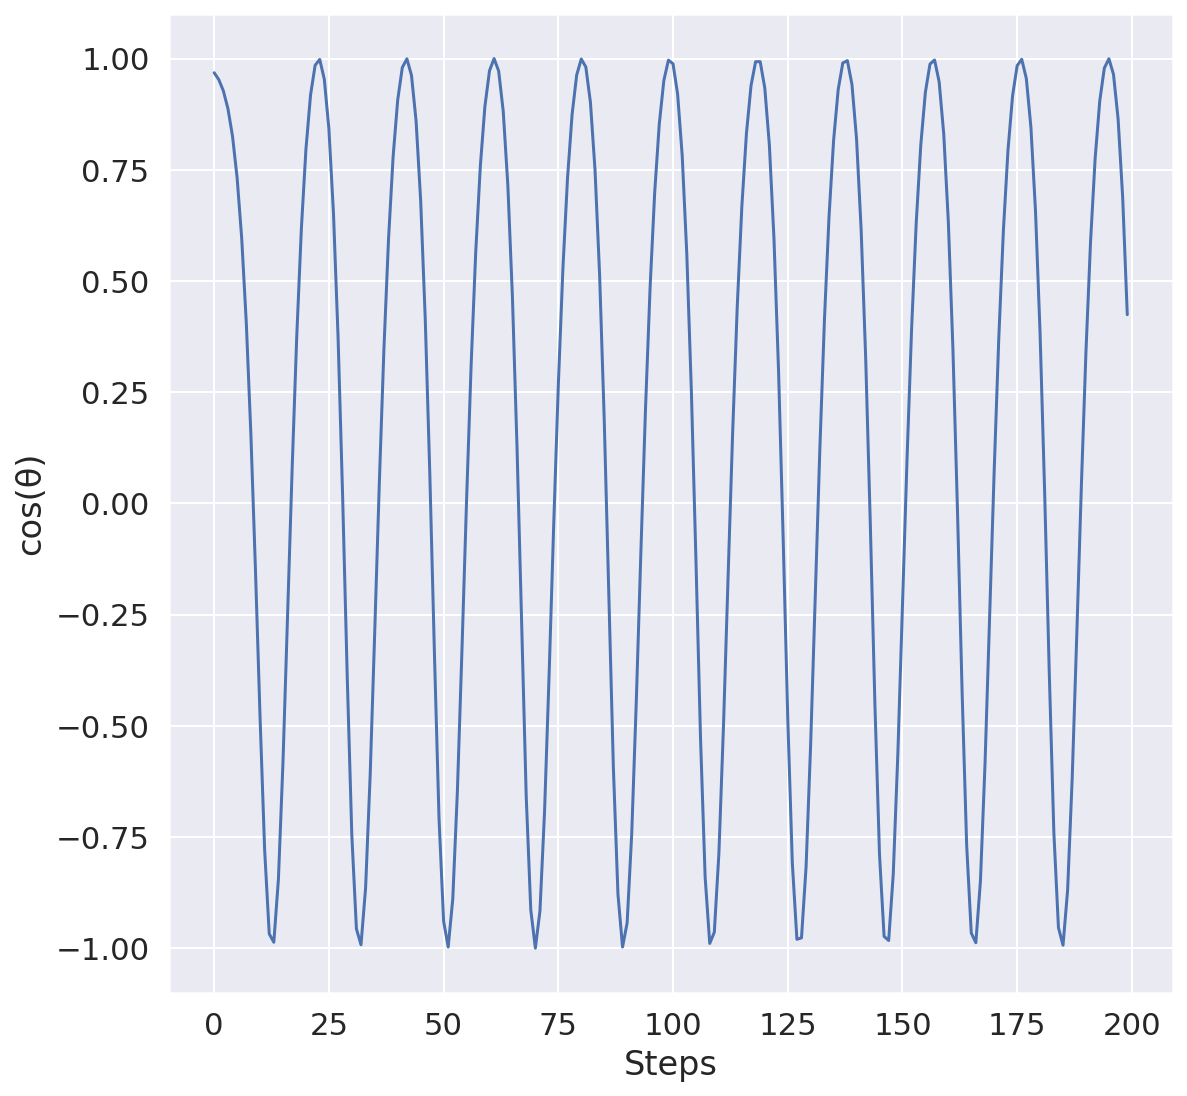

In [7]:
observations = np.array(observations)
plt.plot(observations[:,0])
plt.xlabel('Steps')
plt.ylabel('cos(θ)')
plt.show()

### Creating our own Python Environment

In practice we want to apply one of the agents in *TF-Agents* to our problem. To do this, we have to frame our problem as an environment. So let us look at how to implement an environment in Python.

Let's say we want to train an agent to play the following (Black Jack inspired) card game:

1. The game is played using an infinite deck of cards numbered 1...10.
2. At every turn the agent can do 2 things: get a new random card, or stop the current round.
3. The goal is to get the sum the agents cards as close to 21 as possible at the end of the round, without going over.

An environment that represents the game could look like this:

1. Actions: We have 2 actions. Action 0: get a new card, and Action 1: terminate the current round.
2. Observations: Sum of the cards in the current round.
3. Reward: The objective is to get as close to 21 as possible without going over, so we can achieve this using the following reward at the end of the round:
   sum_of_cards - 21 if sum_of_cards <= 21, else -21


In [8]:
from tf_agents.environments import py_environment


class CardGameEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.int32, minimum=0, name='observation')
        self._state = 0
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
        return ts.restart(np.array([self._state], dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Make sure episodes don't go on forever.
        if action == 1:
            self._episode_ended = True
        elif action == 0:
            new_card = np.random.randint(1, 11)
            self._state += new_card
        else:
            raise ValueError('`action` should be 0 or 1.')

        if self._episode_ended or self._state >= 21:
            reward = self._state - 21 if self._state <= 21 else -21
            return ts.termination(np.array([self._state], dtype=np.int32), reward)
        else:
            return ts.transition(
                np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

Let's make sure we did everything correctly defining the above environment. When creating our own environment we must make sure the observations and time_steps generated follow the correct shapes and types as defined in our specs. These are used to generate the TensorFlow graph and as such can create hard to debug problems if we get them wrong.

To validate our environment we will use a random policy to generate actions and we will iterate over 5 episodes to make sure things are working as intended. An error is raised if we receive a time_step that does not follow the environment specs.

In [9]:
environment = CardGameEnv()
utils.validate_py_environment(environment, episodes=5)

Now that we know the environment is working as intended, let's run this environment using a fixed policy: ask for 3 cards and then end the round.

In [10]:
get_new_card_action = np.array(0, dtype=np.int32)
end_round_action = np.array(1, dtype=np.int32)

environment = CardGameEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(3):
    time_step = environment.step(get_new_card_action)
    print(time_step)
    cumulative_reward += time_step.reward

time_step = environment.step(end_round_action)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0], dtype=int32))
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([8], dtype=int32))
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([18], dtype=int32))
TimeStep(step_type=array(2, dtype=int32), reward=array(-21., dtype=float32), discount=array(0., dtype=float32), observation=array([22], dtype=int32))
TimeStep(step_type=array(2, dtype=int32), reward=array(-21., dtype=float32), discount=array(0., dtype=float32), observation=array([22], dtype=int32))
Final Reward =  -42.0


### Environment Wrappers

An environment wrapper takes a python environment and returns a modified version of the environment. Both the original environment and the modified environment are instances of `py_environment.PyEnvironment`, and multiple wrappers can be chained together.

Some common wrappers can be found in `environments/wrappers.py`. For example:

1. `ActionDiscretizeWrapper`: Converts a continuous action space to a discrete action space.
2. `RunStats`: Captures run statistics of the environment such as number of steps taken, number of episodes completed etc.
3. `TimeLimit`: Terminates the episode after a fixed number of steps.


#### Example 1: Action Discretize Wrapper

InvertedPendulum is a PyBullet environment that accepts continuous actions in the range `[-2, 2]`. If we want to train a discrete action agent such as DQN on this environment, we have to discretize (quantize) the action space. This is exactly what the `ActionDiscretizeWrapper` does. Compare the `action_spec` before and after wrapping:

In [11]:
env = suite_gym.load('Pendulum-v0')
print('Action Spec:', env.action_spec())

discrete_action_env = wrappers.ActionDiscretizeWrapper(env, num_actions=5)
print('\nDiscretized Action Spec:', discrete_action_env.action_spec())

Action Spec: BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-2.0, maximum=2.0)

Discretized Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=4)


The wrapped `discrete_action_env` is an instance of `py_environment.PyEnvironment` and can be treated like a regular python environment.


## TensorFlow Environments

The interface for TF environments is defined in `environments/tf_environment.TFEnvironment` and looks very similar to the Python environments. TF Environments differ from python envs in a couple of ways:

* They generate tensor objects instead of arrays
* TF environments add a batch dimension to the tensors generated when compared to the specs. 

Converting the python environments into TFEnvs allows tensorflow to parellalize operations. For example, one could define a `collect_experience_op` that collects data from the environment and adds to a `replay_buffer`, and a `train_op` that reads from the `replay_buffer` and trains the agent, and run them in parallel naturally in TensorFlow.

In [12]:
class TFEnvironment(object):

    def time_step_spec(self):
        """Describes the `TimeStep` tensors returned by `step()`."""

    def observation_spec(self):
        """Defines the `TensorSpec` of observations provided by the environment."""

    def action_spec(self):
        """Describes the TensorSpecs of the action expected by `step(action)`."""

    def reset(self):
        """Returns the current `TimeStep` after resetting the Environment."""
        return self._reset()

    def current_time_step(self):
        """Returns the current `TimeStep`."""
        return self._current_time_step()

    def step(self, action):
        """Applies the action and returns the new `TimeStep`."""
        return self._step(action)

    @abc.abstractmethod
    def _reset(self):
        """Returns the current `TimeStep` after resetting the Environment."""

    @abc.abstractmethod
    def _current_time_step(self):
        """Returns the current `TimeStep`."""

    @abc.abstractmethod
    def _step(self, action):
        """Applies the action and returns the new `TimeStep`."""

The `current_time_step()` method returns the current time_step and initializes the environment if needed.

The `reset()` method forces a reset in the environment and returns the current_step.

If the `action` doesn't depend on the previous `time_step` a `tf.control_dependency` is needed in `Graph` mode.

For now, let us look at how `TFEnvironments` are created.

### Creating our own TensorFlow Environment

This is more complicated than creating environments in Python, not covered here. An example is available [here](https://github.com/tensorflow/agents/blob/master/tf_agents/environments/tf_environment_test.py). The more common use case is to implement our environment in Python and wrap it in TensorFlow using our `TFPyEnvironment` wrapper (see below).

### Wrapping a Python Environment in TensorFlow

We can easily wrap any Python environment into a TensorFlow environment using the `TFPyEnvironment` wrapper.

In [13]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

print(isinstance(tf_env, tf_environment.TFEnvironment))
print("\nTimeStep Specs:", tf_env.time_step_spec())
print("\nAction Specs:", tf_env.action_spec())

True

TimeStep Specs: TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)))

Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))


Note the specs are now of type: `(Bounded)TensorSpec`.

### Usage Examples

#### Simple Example

In [14]:
env = suite_gym.load('CartPole-v0')

tf_env = tf_py_environment.TFPyEnvironment(env)
# reset() creates the initial time_step after resetting the environment.
time_step = tf_env.reset()
num_steps = 3
transitions = []
reward = 0
for i in range(num_steps):
    action = tf.constant([i % 2])
    # applies the action and returns the new TimeStep.
    next_time_step = tf_env.step(action)
    transitions.append([time_step, action, next_time_step])
    reward += next_time_step.reward
    time_step = next_time_step

np_transitions = tf.nest.map_structure(lambda x: x.numpy(), transitions)
print('\n'.join(map(str, np_transitions)))
print('\nTotal reward:', reward.numpy())

[TimeStep(step_type=array([0], dtype=int32), reward=array([0.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[-0.04411689, -0.03410015,  0.03182163,  0.03646041]],
      dtype=float32)), array([0], dtype=int32), TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[-0.04479889, -0.22966364,  0.03255084,  0.3390111 ]],
      dtype=float32))]
[TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[-0.04479889, -0.22966364,  0.03255084,  0.3390111 ]],
      dtype=float32)), array([1], dtype=int32), TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([1.], dtype=float32), observation=array([[-0.04939216, -0.03501962,  0.03933106,  0.05676801]],
      dtype=float32))]
[TimeStep(step_type=array([1], dtype=int32), reward=array([1.], dtype=float32), discount=array([

#### Whole Episodes

In [15]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    episode_reward = 0
    episode_steps = 0
    while not time_step.is_last():
        action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
        time_step = tf_env.step(action)
        episode_steps += 1
        episode_reward += time_step.reward.numpy()
    rewards.append(episode_reward)
    steps.append(episode_steps)
    time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('\navg_length', avg_length, 'avg_reward:', avg_reward)

num_episodes: 5 num_steps: 98

avg_length 19.6 avg_reward: 19.6


# Policies

## Introduction

In Reinforcement  Learning terminology, policies map an observation from the environment to an action or a distribution over actions. In TF-Agents, observations from the environment are contained in a named tuple `TimeStep('step_type', 'discount', 'reward', 'observation')`, and policies map timesteps to actions or distributions over actions. Most policies use  `timestep.observation`, some policies use `timestep.step_type` (e.g. to reset the state at the beginning of an episode in stateful policies), but `timestep.discount` and `timestep.reward` are usually ignored.

Policies are related to other components in TF-Agents in the following way. Most policies have a neural network to compute actions and/or distributions over actions from TimeSteps. Agents can contain one or more policies for different purposes, e.g. a main policy that is being trained for deployment, and a noisy policy for data collection. Policies can be saved/restored, and can be used independently of the agent for data collection, evaluation etc.

Some policies are easier to write in Tensorflow (e.g. those with a neural network), whereas others are easier to write in Python (e.g. following a script of actions). So in TF agents, we allow both Python and Tensorflow policies. Moreover, policies written in TensorFlow might have to be used in a Python environment, or vice versa, e.g. a TensorFlow policy is used for training but later deployed in a production python environment. To make this easier, we provide wrappers for converting between python and TensorFlow policies.

Another interesting class of policies are policy wrappers, which modify a given policy in a certain way, e.g. add a particular type of noise, make a greedy or epsilon-greedy version of a stochastic policy, randomly mix multiple policies etc.  

## Setup

In [16]:
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.networks import network

from tf_agents.policies import py_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import scripted_py_policy

from tf_agents.policies import tf_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import actor_policy
from tf_agents.policies import q_policy
from tf_agents.policies import greedy_policy

from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

## Python Policies

The interface for Python policies is defined in `policies/py_policy.PyPolicy`. The main methods are:


In [17]:
class Base(object):

    @abc.abstractmethod
    def __init__(self, time_step_spec, action_spec, policy_state_spec=()):
        self._time_step_spec = time_step_spec
        self._action_spec = action_spec
        self._policy_state_spec = policy_state_spec

    @abc.abstractmethod
    def reset(self, policy_state=()):
        # return initial_policy_state.
        pass

    @abc.abstractmethod
    def action(self, time_step, policy_state=()):
        # return a PolicyStep(action, state, info) named tuple.
        pass

    @abc.abstractmethod
    def distribution(self, time_step, policy_state=()):
        # Not implemented in python, only for TF policies.
        pass

    @abc.abstractmethod
    def update(self, policy):
        # update self to be similar to the input `policy`.
        pass

    @property
    def time_step_spec(self):
        return self._time_step_spec

    @property
    def action_spec(self):
        return self._action_spec

    @property
    def policy_state_spec(self):
        return self._policy_state_spec

The most important method is `action(time_step)` which maps a `time_step` containing an observation from the environment to a PolicyStep named tuple containing the following attributes:

*  `action`: The action to be applied to the environment.
*  `state`: The state of the policy (e.g. RNN state) to be fed into the next call to action.
*  `info`: Optional side information such as action log probabilities.

The `time_step_spec` and `action_spec` are specifications for the input time step and the output action. Policies also have a `reset` function which is typically used for resetting the state in stateful policies. The `update(new_policy)` function updates `self` towards `new_policy`.

Now, let us look at a couple of examples of python policies.


### Example 1: Random Python Policy

A simple example of a `PyPolicy` is the `RandomPyPolicy` which generates random actions for the discrete/continuous given action_spec. The input `time_step` is ignored.

In [18]:
action_spec = array_spec.BoundedArraySpec((2,), np.int32, -10, 10)
my_random_py_policy = random_py_policy.RandomPyPolicy(time_step_spec=None,
                                                      action_spec=action_spec)
time_step = None
action_step = my_random_py_policy.action(time_step)
print(action_step)
action_step = my_random_py_policy.action(time_step)
print(action_step)

PolicyStep(action=array([7, 8], dtype=int32), state=(), info=())
PolicyStep(action=array([-9, 10], dtype=int32), state=(), info=())


### Example 2: Scripted Python Policy

A scripted policy plays back a script of actions represented as a list of `(num_repeats, action)` tuples. Every time the `action` function is called, it returns the next action from the list until the specified number of repeats is done, and then moves on to the next action in the list. The `reset` method can be called to start executing from the beginning of the list.

In [19]:
action_spec = array_spec.BoundedArraySpec((2,), np.int32, -10, 10)
action_script = [(1, np.array([5, 2], dtype=np.int32)),
                 # Setting `num_repeates` to 0 will skip this action.
                 (0, np.array([0, 0], dtype=np.int32)),
                 (2, np.array([1, 2], dtype=np.int32)),
                 (1, np.array([3, 4], dtype=np.int32))]

my_scripted_py_policy = scripted_py_policy.ScriptedPyPolicy(
    time_step_spec=None, action_spec=action_spec, action_script=action_script)

policy_state = my_scripted_py_policy.get_initial_state()
time_step = None
print('Executing scripted policy...')
action_step = my_scripted_py_policy.action(time_step, policy_state)
print(action_step)
action_step = my_scripted_py_policy.action(time_step, action_step.state)
print(action_step)
action_step = my_scripted_py_policy.action(time_step, action_step.state)
print(action_step)

print('Resetting my_scripted_py_policy...')
policy_state = my_scripted_py_policy.get_initial_state()
action_step = my_scripted_py_policy.action(time_step, policy_state)
print(action_step)

Executing scripted policy...
PolicyStep(action=array([5, 2], dtype=int32), state=[0, 1], info=())
PolicyStep(action=array([1, 2], dtype=int32), state=[2, 1], info=())
PolicyStep(action=array([1, 2], dtype=int32), state=[2, 2], info=())
Resetting my_scripted_py_policy...
PolicyStep(action=array([5, 2], dtype=int32), state=[0, 1], info=())


## TensorFlow Policies

TensorFlow policies follow the same interface as Python policies. Let us look at a few examples.

### Example 1: Random TF Policy

A RandomTFPolicy can be used to generate random actions according to a given discrete/continuous `action_spec`. The input `time_step` is ignored.


In [20]:
action_spec = tensor_spec.BoundedTensorSpec(
    (2,), tf.float32, minimum=-1, maximum=3)
input_tensor_spec = tensor_spec.TensorSpec((2,), tf.float32)
time_step_spec = ts.time_step_spec(input_tensor_spec)

my_random_tf_policy = random_tf_policy.RandomTFPolicy(
    action_spec=action_spec, time_step_spec=time_step_spec)
observation = tf.ones(time_step_spec.observation.shape)
time_step = ts.restart(observation)
action_step = my_random_tf_policy.action(time_step)

print('Action:')
print(action_step.action)

Action:
tf.Tensor([0.9778981 2.1087189], shape=(2,), dtype=float32)


### Example 2: Actor Policy

An actor policy can be created using either a network that maps `time_steps` to actions or a network that maps `time_steps` to distributions over actions.


#### Using an action network

Let us define a network as follows:

In [21]:
class ActionNet(network.Network):

    def __init__(self, input_tensor_spec, output_tensor_spec):
        super(ActionNet, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=(),
            name='ActionNet')
        self._output_tensor_spec = output_tensor_spec
        self._sub_layers = [
            tf.keras.layers.Dense(
                action_spec.shape.num_elements(), activation=tf.nn.tanh),
        ]

    def call(self, observations, step_type, network_state):
        del step_type

        output = tf.cast(observations, dtype=tf.float32)
        for layer in self._sub_layers:
            output = layer(output)
        actions = tf.reshape(
            output, [-1] + self._output_tensor_spec.shape.as_list())

        # Scale and shift actions to the correct range if necessary.
        return actions, network_state

In TensorFlow most network layers are designed for batch operations, so we expect the input time_steps to be batched, and the output of the network will be batched as well. Also the network is responsible for producing actions in the correct range of the given action_spec. This is conventionally done using e.g. a tanh activation for the final layer to produce actions in [-1, 1] and then scaling and shifting this to the correct range as the input action_spec (e.g. see `tf_agents/agents/ddpg/networks.actor_network()`).

Now, we can create an actor policy using the above network.

In [22]:
input_tensor_spec = tensor_spec.TensorSpec((4,), tf.float32)
time_step_spec = ts.time_step_spec(input_tensor_spec)
action_spec = tensor_spec.BoundedTensorSpec((3,),
                                            tf.float32,
                                            minimum=-1,
                                            maximum=1)

action_net = ActionNet(input_tensor_spec, action_spec)

my_actor_policy = actor_policy.ActorPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    actor_network=action_net)

We can apply it to any batch of time_steps that follow time_step_spec:

In [23]:
batch_size = 2
observations = tf.ones([2] + time_step_spec.observation.shape.as_list())

time_step = ts.restart(observations, batch_size)

action_step = my_actor_policy.action(time_step)
print('Action:')
print(action_step.action)

distribution_step = my_actor_policy.distribution(time_step)
print('\nAction distribution:')
print(distribution_step.action)

Action:
tf.Tensor(
[[-0.77003115  0.90532035  0.18195158]
 [-0.77003115  0.90532035  0.18195158]], shape=(2, 3), dtype=float32)

Action distribution:
tfp.distributions.Deterministic("Deterministic", batch_shape=[2, 3], event_shape=[], dtype=float32)


In the above example, we created the policy using an action network that produces an action tensor. In this case, `policy.distribution(time_step)` is a deterministic (delta) distribution around the output of `policy.action(time_step)`. One way to produce a stochastic policy is to wrap the actor policy in a policy wrapper that adds noise to the actions. Another way is to create the actor policy using an action distribution network instead of an action network as shown below.

#### Using an action distribution network

In [24]:
class ActionDistributionNet(ActionNet):

    def call(self, observations, step_type, network_state):
        action_means, network_state = super(ActionDistributionNet, self).call(
            observations, step_type, network_state)

        action_std = tf.ones_like(action_means)
        return tfp.distributions.Normal(action_means, action_std), network_state


action_distribution_net = ActionDistributionNet(input_tensor_spec, action_spec)

my_actor_policy = actor_policy.ActorPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    actor_network=action_distribution_net)

action_step = my_actor_policy.action(time_step)
print('Action:')
print(action_step.action)
distribution_step = my_actor_policy.distribution(time_step)
print('\nAction distribution:')
print(distribution_step.action)

Action:
tf.Tensor(
[[0.38985267 1.         0.20359254]
 [0.385986   1.         0.38213336]], shape=(2, 3), dtype=float32)

Action distribution:
tfp.distributions.Normal("ActionNet_Normal", batch_shape=[2, 3], event_shape=[], dtype=float32)


Note that in the above, actions are clipped to the range of the given action spec [-1, 1]. This is because a constructor argument of ActorPolicy clip=True by default. Setting this to false will return unclipped actions produced by the network. 

Stochastic policies can be converted to deterministic policies using, for example, a GreedyPolicy wrapper which chooses `stochastic_policy.distribution().mode()` as its action, and a deterministic/delta distribution around this greedy action as its `distribution()`.

### Example 3: Q Policy

A Q policy is used in agents like DQN and is based on a Q network that predicts a Q value for each discrete action. For a given time step, the action distribution in the Q Policy is a categorical distribution created using the q values as logits.


In [25]:
input_tensor_spec = tensor_spec.TensorSpec((4,), tf.float32)
time_step_spec = ts.time_step_spec(input_tensor_spec)
action_spec = tensor_spec.BoundedTensorSpec((1,),
                                            tf.int32,
                                            minimum=-1,
                                            maximum=1)
num_actions = action_spec.maximum - action_spec.minimum + 1


class QNetwork(network.Network):

    def __init__(self, input_tensor_spec, action_spec, num_actions=num_actions, name=None):
        super(QNetwork, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=(),
            name=name)
        self._sub_layers = [
            tf.keras.layers.Dense(num_actions),
        ]

    def call(self, inputs, step_type=None, network_state=()):
        del step_type
        inputs = tf.cast(inputs, tf.float32)
        for layer in self._sub_layers:
            inputs = layer(inputs)
        return inputs, network_state


batch_size = 2
observation = tf.ones(
    [batch_size] + time_step_spec.observation.shape.as_list())
time_steps = ts.restart(observation, batch_size=batch_size)

my_q_network = QNetwork(
    input_tensor_spec=input_tensor_spec,
    action_spec=action_spec)
my_q_policy = q_policy.QPolicy(
    time_step_spec, action_spec, q_network=my_q_network)
action_step = my_q_policy.action(time_steps)
distribution_step = my_q_policy.distribution(time_steps)

print('Action:')
print(action_step.action)

print('\nAction distribution:')
print(distribution_step.action)

Action:
tf.Tensor(
[[0]
 [0]], shape=(2, 1), dtype=int32)

Action distribution:
tfp.distributions.ShiftedCategorical("ShiftedCategorical", batch_shape=[2, 1], event_shape=[], dtype=int32)


## Policy Wrappers

A policy wrapper can be used to wrap and modify a given policy, e.g. add noise. Policy wrappers are a subclass of Policy (Python/TensorFlow) and can therefore be used just like any other policy. 

### Example: Greedy Policy


A greedy wrapper can be used to wrap any TensorFlow policy that implements `distribution()`. `GreedyPolicy.action()` will return `wrapped_policy.distribution().mode()` and `GreedyPolicy.distribution()` is a deterministic/delta distribution around `GreedyPolicy.action()`:

In [26]:
my_greedy_policy = greedy_policy.GreedyPolicy(my_q_policy)

action_step = my_greedy_policy.action(time_steps)
print('Action:')
print(action_step.action)

distribution_step = my_greedy_policy.distribution(time_steps)
print('\nAction distribution:')
print(distribution_step.action)

Action:
tf.Tensor(
[[-1]
 [-1]], shape=(2, 1), dtype=int32)

Action distribution:
tfp.distributions.DeterministicWithLogProb("Deterministic", batch_shape=[2, 1], event_shape=[], dtype=int32)


# Drivers

## Introduction

A common pattern in reinforcement learning is to execute a policy in an environment for a specified number of steps or episodes. This happens, for example, during data collection, evaluation and generating a video of the agent.

While this is relatively straightforward to write in python, it is much more complex to write and debug in TensorFlow because it involves `tf.while` loops, `tf.cond` and `tf.control_dependencies`. Therefore we abstract this notion of a run loop into a class called `driver`, and provide well tested implementations both in Python and TensorFlow.

Additionally, the data encountered by the driver at each step is saved in a named tuple called Trajectory and broadcast to a set of observers such as replay buffers and metrics. This data includes the observation from the environment, the action recommended by the policy, the reward obtained, the type of the current and the next step, etc.

## Setup

In [27]:
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_py_policy
from tf_agents.policies import random_tf_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

tf.compat.v1.enable_v2_behavior()

## Python Drivers

The `PyDriver` class takes a python environment, a python policy and a list of observers to update at each step. The main method is `run()`, which steps the environment using actions from the policy until at least one of the following termination criteria is met: The number of steps reaches `max_steps` or the number of episodes reaches `max_episodes`.

The implementation is roughly as follows:


```python
class PyDriver(object):

  def __init__(self, env, policy, observers, max_steps=1, max_episodes=1):
    self._env = env
    self._policy = policy
    self._observers = observers or []
    self._max_steps = max_steps or np.inf
    self._max_episodes = max_episodes or np.inf

  def run(self, time_step, policy_state=()):
    num_steps = 0
    num_episodes = 0
    while num_steps < self._max_steps and num_episodes < self._max_episodes:

      # Compute an action using the policy for the given time_step
      action_step = self._policy.action(time_step, policy_state)

      # Apply the action to the environment and get the next step
      next_time_step = self._env.step(action_step.action)

      # Package information into a trajectory
      traj = trajectory.Trajectory(
         time_step.step_type,
         time_step.observation,
         action_step.action,
         action_step.info,
         next_time_step.step_type,
         next_time_step.reward,
         next_time_step.discount)

      for observer in self._observers:
        observer(traj)

      # Update statistics to check termination
      num_episodes += np.sum(traj.is_last())
      num_steps += np.sum(~traj.is_boundary())

      time_step = next_time_step
      policy_state = action_step.state

    return time_step, policy_state

```

Now, let us run through the example of running a random policy on the CartPole environment, saving the results to a replay buffer and computing some metrics.

In [28]:
env = suite_gym.load('CartPole-v0')
policy = random_py_policy.RandomPyPolicy(time_step_spec=env.time_step_spec(),
                                         action_spec=env.action_spec())
replay_buffer = []
metric = py_metrics.AverageReturnMetric()
observers = [replay_buffer.append, metric]
driver = py_driver.PyDriver(
    env, policy, observers, max_steps=20, max_episodes=1)

initial_time_step = env.reset()
final_time_step, _ = driver.run(initial_time_step)

print('Replay Buffer:')
for traj in replay_buffer:
    print(traj)

print('Average Return: ', metric.result())

Replay Buffer:
Trajectory(step_type=array(0, dtype=int32), observation=array([ 0.01684707,  0.02026141,  0.04179439, -0.03928119], dtype=float32), action=array(1), policy_info=(), next_step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32))
Trajectory(step_type=array(1, dtype=int32), observation=array([ 0.0172523 ,  0.21475989,  0.04100877, -0.31849015], dtype=float32), action=array(1), policy_info=(), next_step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32))
Trajectory(step_type=array(1, dtype=int32), observation=array([ 0.02154749,  0.40927452,  0.03463897, -0.5979636 ], dtype=float32), action=array(1), policy_info=(), next_step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32))
Trajectory(step_type=array(1, dtype=int32), observation=array([ 0.02973299,  0.60389507,  0.0226797 , -0.8795375 ], dtype=float32), action=array(1), policy_info=(), next_st

## TensorFlow Drivers

We also have drivers in TensorFlow which are functionally similar to Python drivers, but use TF environments, TF policies, TF observers etc. We currently have 2 TensorFlow drivers: `DynamicStepDriver`, which terminates after a given number of (valid) environment steps and `DynamicEpisodeDriver`, which terminates after a given number of episodes. Let us look at an example of the DynamicEpisode in action.


In [29]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

tf_policy = random_tf_policy.RandomTFPolicy(action_spec=tf_env.action_spec(),
                                            time_step_spec=tf_env.time_step_spec())


num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
observers = [num_episodes, env_steps]
driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=2)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('\nNumber of Steps: ', env_steps.result().numpy())
print('\nNumber of Episodes: ', num_episodes.result().numpy())

final_time_step TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03426698,  0.01751157, -0.04660691, -0.03253927]],
      dtype=float32)>)

Number of Steps:  37

Number of Episodes:  2


In [30]:
# Continue running from previous state
final_time_step, _ = driver.run(final_time_step, policy_state)

print('final_time_step', final_time_step)
print('\nNumber of Steps: ', env_steps.result().numpy())
print('\nNumber of Episodes: ', num_episodes.result().numpy())

final_time_step TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.03310161, -0.04367052, -0.03266289, -0.03867196]],
      dtype=float32)>)

Number of Steps:  115

Number of Episodes:  4


# Replay Buffers

## Introduction

Reinforcement learning algorithms use replay buffers to store trajectories of experience when executing a policy in an environment. During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

Here we explore two types of replay buffers: python-backed and tensorflow-backed, sharing a common API. In the following sections, we describe the API, each of the buffer implementations and how to use them during data collection training.


## Setup

In [31]:
from tf_agents import specs
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.replay_buffers import py_uniform_replay_buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step

tf.compat.v1.enable_v2_behavior()

## Replay Buffer API

The Replay Buffer class has the following definition and methods:

```python
class ReplayBuffer(tf.Module):
  """Abstract base class for TF-Agents replay buffer."""

  def __init__(self, data_spec, capacity):
    """Initializes the replay buffer.

    Args:
      data_spec: A spec or a list/tuple/nest of specs describing
        a single item that can be stored in this buffer
      capacity: number of elements that the replay buffer can hold.
    """

  @property
  def data_spec(self):
    """Returns the spec for items in the replay buffer."""

  @property
  def capacity(self):
    """Returns the capacity of the replay buffer."""

  def add_batch(self, items):
    """Adds a batch of items to the replay buffer."""

  def get_next(self,
               sample_batch_size=None,
               num_steps=None,
               time_stacked=True):
    """Returns an item or batch of items from the buffer."""

  def as_dataset(self,
                 sample_batch_size=None,
                 num_steps=None,
                 num_parallel_calls=None):
    """Creates and returns a dataset that returns entries from the buffer."""


  def gather_all(self):
    """Returns all the items in buffer."""
    return self._gather_all()

  def clear(self):
    """Resets the contents of replay buffer"""

```

Note that when the replay buffer object is initialized, it requires the `data_spec` of the elements that it will store. This spec corresponds to the `TensorSpec` of trajectory elements that will be added to the buffer. This spec is usually acquired by looking at an agent's `agent.collect_data_spec` which defines the shapes, types, and structures expected by the agent when training (more on that later)

## TFUniformReplayBuffer

`TFUniformReplayBuffer` is the most commonly used replay buffer in TF-Agents, thus we will use it here. In `TFUniformReplayBuffer` the backing buffer storage is done by tensorflow variables and thus is part of the compute graph. 

The buffer stores batches of elements and has a maximum capacity `max_length` elements per batch segment. Thus, the total buffer capacity is `batch_size` x `max_length` elements. The elements stored in the buffer must all have a matching data spec. When the replay buffer is used for data collection, the spec is the agent's collect data spec.


### Creating the buffer:
To create a `TFUniformReplayBuffer` we pass in:
1. the spec of the data elements that the buffer will store
2. the `batch size` corresponding to the batch size of the buffer 
3. the `max_length` number of elements per batch segment

Here is an example of creating a `TFUniformReplayBuffer` with sample data specs, `batch_size` 32 and `max_length` 1000.

In [32]:
data_spec = (
    tf.TensorSpec([3], tf.float32, 'action'),
    (
        tf.TensorSpec([5], tf.float32, 'touch_sensor'),
        tf.TensorSpec([3, 2], tf.float32, 'camera')
    )
)

batch_size = 32
max_length = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec,
    batch_size=batch_size,
    max_length=max_length)

### Writing to the buffer:
To add elements to the replay buffer, we use the `add_batch(items)` method where `items` is a list/tuple/nest of tensors representing the batch of items to be added to the buffer. Each element of `items` must have an outer dimension equal `batch_size` and the remaining dimensions must adhere to the data spec of the item (same as the data specs passed to the replay buffer constructor). 

Here's an example of adding a batch of items 


In [33]:
action = tf.constant(1 * np.ones(
    data_spec[0].shape.as_list(), dtype=np.float32))
lidar = tf.constant(
    2 * np.ones(data_spec[1][0].shape.as_list(), dtype=np.float32))
camera = tf.constant(
    3 * np.ones(data_spec[1][1].shape.as_list(), dtype=np.float32))

values = (action, (lidar, camera))
values_batched = tf.nest.map_structure(lambda t: tf.stack([t] * batch_size),
                                       values)

replay_buffer.add_batch(values_batched)

### Reading from the buffer

There are three ways to read data from the `TFUniformReplayBuffer`:

1. `get_next()` - returns one sample from the buffer. The sample batch size and number of timesteps returned can be specified via arguments to this method.
2. `as_dataset()` - returns the replay buffer as a `tf.data.Dataset`. One can then create a dataset iterator and iterate through the samples of the items in the buffer.
3. `gather_all()` - returns all the items in the buffer as a Tensor with shape `[batch, time, data_spec]`

Below are examples of how to read from the replay buffer using each of these methods:

In [34]:
# add more items to the buffer before reading
for _ in range(5):
    replay_buffer.add_batch(values_batched)

# Get one sample from the replay buffer with batch size 10 and 1 timestep:

sample = replay_buffer.get_next(sample_batch_size=10, num_steps=1)

# Convert the replay buffer to a tf.data.Dataset and iterate through it
dataset = replay_buffer.as_dataset(
    sample_batch_size=4,
    num_steps=2)

iterator = iter(dataset)
print("Iterator trajectories:")
trajectories = []
for _ in range(3):
    t, _ = next(iterator)
    trajectories.append(t)

print(tf.nest.map_structure(lambda t: t.shape, trajectories))

# Read all elements in the replay buffer:
trajectories = replay_buffer.gather_all()

print("\nTrajectories from gather all:")
print(tf.nest.map_structure(lambda t: t.shape, trajectories))

Iterator trajectories:
[(TensorShape([4, 2, 3]), (TensorShape([4, 2, 5]), TensorShape([4, 2, 3, 2]))), (TensorShape([4, 2, 3]), (TensorShape([4, 2, 5]), TensorShape([4, 2, 3, 2]))), (TensorShape([4, 2, 3]), (TensorShape([4, 2, 5]), TensorShape([4, 2, 3, 2])))]

Trajectories from gather all:
(TensorShape([32, 6, 3]), (TensorShape([32, 6, 5]), TensorShape([32, 6, 3, 2])))


## PyUniformReplayBuffer
`PyUniformReplayBuffer`  has the same functionally as the `TFUniformReplayBuffer` but instead of tf variables, its data is stored in numpy arrays. This buffer can be used for out-of-graph data collection. Having the backing storage in numpy may make it easier for some applications to do data manipulation (such as indexing for updating priorities) without using Tensorflow variables. However, this implementation won't have the benefit of graph optimizations with Tensorflow. 

Below is an example of instantiating a `PyUniformReplayBuffer` from the agent's policy trajectory specs:

In [35]:
replay_buffer_capacity = 1000*32  # same capacity as the TFUniformReplayBuffer

py_replay_buffer = py_uniform_replay_buffer.PyUniformReplayBuffer(
    capacity=replay_buffer_capacity,
    data_spec=tensor_spec.to_nest_array_spec(data_spec))

## Using replay buffers during training
Now that we know how to created a replay buffer, write items to it and read from it, we can use it to store trajectories during training of our agents. 

### Data collection
First, let's look at how to use the replay buffer during data collection.

In TF-Agents we use a `Driver` to collect experience in an environment. To use a `Driver`, we specify an `Observer` that is a function for the `Driver` to execute when it receives a trajectory. 

Thus, to add trajectory elements to the replay buffer, we add an observer that calls `add_batch(items)` to add a (batch of) items on the replay buffer. 

Below is an example of this with `TFUniformReplayBuffer`. We first create an environment, a network and an agent. Then we create a `TFUniformReplayBuffer`. Note that the specs of the trajectory elements in the replay buffer are equal to the agent's collect data spec. We then set its `add_batch` method as the observer for the driver that will do the data collect during our training:


In [36]:
env = suite_gym.load('CartPole-v0')
tf_env = tf_py_environment.TFPyEnvironment(env)

q_net = q_network.QNetwork(
    tf_env.time_step_spec().observation,
    tf_env.action_spec(),
    fc_layer_params=(100,))

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(0.001))

replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity)

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=replay_observer,
    num_steps=collect_steps_per_iteration).run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


### Reading data for a train step

After adding trajectory elements to the replay buffer, we can read batches of trajectories from the replay buffer to use as input data for a train step.

Here is an example of how to train on trajectories from the replay buffer in a training loop: 

In [37]:
# Read the replay buffer as a Dataset,
# read batches of 4 elements, each with 2 timesteps:
dataset = replay_buffer.as_dataset(
    sample_batch_size=4,
    num_steps=2)

iterator = iter(dataset)

num_train_steps = 10

for _ in range(num_train_steps):
    trajectories, _ = next(iterator)
    loss = agent.train(experience=trajectories)

# Networks

## Introduction

Lets look at how to define custom networks for our agents. The networks help us define the model that is trained by agents. In TF-Agents we will find several different types of networks which are useful across agents:

**Main Networks**

* **QNetwork**: Used in Qlearning for environments with discrete actions, this network maps an observation to value estimates for each possible action.
* **CriticNetworks**: Also referred to as `ValueNetworks` in literature, learns to estimate some version of a Value function mapping some state into an estimate for the expected return of a policy. These networks estimate how good the state the agent is currently in is.
* **ActorNetworks**: Learn a mapping from observations to actions. These networks are usually used by our policies to generate actions.
* **ActorDistributionNetworks**: Similar to `ActorNetworks` but these generate a distribution which a policy can then sample to generate actions.

**Helper Networks**
* **EncodingNetwork**: Allows users to easily define a mapping of pre-processing layers to apply to a network's input.
* **DynamicUnrollLayer**: Automatically resets the network's state on episode boundaries as it is applied over a time sequence.
* **ProjectionNetwork**: Networks like `CategoricalProjectionNetwork` or `NormalProjectionNetwork` take inputs and generate the required parameters to generate Categorical, or Normal distributions.

All examples in TF-Agents come with pre-configured networks. However these networks are not setup to handle complex observations.

## Setup

In [38]:
from tf_agents.environments import random_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import encoding_network
from tf_agents.networks import network
from tf_agents.networks import utils
from tf_agents.specs import array_spec
from tf_agents.utils import common as common_utils
from tf_agents.utils import nest_utils

tf.compat.v1.enable_v2_behavior()

## Defining Networks

### Network API

In TF-Agents we subclass from Keras Networks. With it we can:

* Simplify copy operations required when creating target networks.
* Perform automatic variable creation when calling `network.variables()`.
* Validate inputs based on network input_specs.

## EncodingNetwork

As mentioned above the `EncodingNetwork` allows us to easily define a mapping of pre-processing layers to apply to a network's input to generate some encoding.

The EncodingNetwork is composed of the following mostly optional layers:

  * Preprocessing layers
  * Preprocessing combiner
  * Conv2D 
  * Flatten
  * Dense 

The special thing about encoding networks is that input preprocessing is applied. Input preprocessing is possible via `preprocessing_layers` and `preprocessing_combiner` layers.  Each of these can be specified as a nested structure. If the `preprocessing_layers` nest is shallower than `input_tensor_spec`, then the layers will get the subnests. For example, if:

```
input_tensor_spec = ([TensorSpec(3)] * 2, [TensorSpec(3)] * 5)
preprocessing_layers = (Layer1(), Layer2())
```

then preprocessing will call:

```
preprocessed = [preprocessing_layers[0](observations[0]),
                preprocessing_layers[1](obsrevations[1])]
```

However if

```
preprocessing_layers = ([Layer1() for _ in range(2)],
                        [Layer2() for _ in range(5)])
```

then preprocessing will call:

```python
preprocessed = [
  layer(obs) for layer, obs in zip(flatten(preprocessing_layers),
                                    flatten(observations))
]
```


### Custom Networks

To create our own networks we will only have to override the `__init__` and `call` methods. Let's create a custom network using what we learned about `EncodingNetworks` to create an ActorNetwork that takes observations which contain an image and a vector.


In [39]:
class ActorNetwork(network.Network):

    def __init__(self,
                 observation_spec,
                 action_spec,
                 preprocessing_layers=None,
                 preprocessing_combiner=None,
                 conv_layer_params=None,
                 fc_layer_params=(75, 40),
                 dropout_layer_params=None,
                 activation_fn=tf.keras.activations.relu,
                 enable_last_layer_zero_initializer=False,
                 name='ActorNetwork'):
        super(ActorNetwork, self).__init__(
            input_tensor_spec=observation_spec, state_spec=(), name=name)

        # For simplicity we will only support a single action float output.
        self._action_spec = action_spec
        flat_action_spec = tf.nest.flatten(action_spec)
        if len(flat_action_spec) > 1:
            raise ValueError(
                'Only a single action is supported by this network')
        self._single_action_spec = flat_action_spec[0]
        if self._single_action_spec.dtype not in [tf.float32, tf.float64]:
            raise ValueError(
                'Only float actions are supported by this network.')

        kernel_initializer = tf.keras.initializers.VarianceScaling(
            scale=1. / 3., mode='fan_in', distribution='uniform')
        self._encoder = encoding_network.EncodingNetwork(
            observation_spec,
            preprocessing_layers=preprocessing_layers,
            preprocessing_combiner=preprocessing_combiner,
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params,
            dropout_layer_params=dropout_layer_params,
            activation_fn=activation_fn,
            kernel_initializer=kernel_initializer,
            batch_squash=False)

        initializer = tf.keras.initializers.RandomUniform(
            minval=-0.003, maxval=0.003)

        self._action_projection_layer = tf.keras.layers.Dense(
            flat_action_spec[0].shape.num_elements(),
            activation=tf.keras.activations.tanh,
            kernel_initializer=initializer,
            name='action')

    def call(self, observations, step_type=(), network_state=()):
        outer_rank = nest_utils.get_outer_rank(
            observations, self.input_tensor_spec)
        # We use batch_squash here in case the observations have a time sequence
        # compoment.
        batch_squash = utils.BatchSquash(outer_rank)
        observations = tf.nest.map_structure(
            batch_squash.flatten, observations)

        state, network_state = self._encoder(
            observations, step_type=step_type, network_state=network_state)
        actions = self._action_projection_layer(state)
        actions = common_utils.scale_to_spec(actions, self._single_action_spec)
        actions = batch_squash.unflatten(actions)
        return tf.nest.pack_sequence_as(self._action_spec, [actions]), network_state

Let's create a `RandomPyEnvironment` to generate structured observations and validate our implementation.

In [40]:
action_spec = array_spec.BoundedArraySpec(
    (3,), np.float32, minimum=0, maximum=10)
observation_spec = {
    'image': array_spec.BoundedArraySpec((16, 16, 3), np.float32, minimum=0,
                                         maximum=255),
    'vector': array_spec.BoundedArraySpec((5,), np.float32, minimum=-100,
                                          maximum=100)}

random_env = random_py_environment.RandomPyEnvironment(
    observation_spec, action_spec=action_spec)

# Convert the environment to a TFEnv to generate tensors.
tf_env = tf_py_environment.TFPyEnvironment(random_env)

Since we've defined the observations to be a dict we need to create preprocessing layers to handle these.

In [41]:
preprocessing_layers = {
    'image': tf.keras.models.Sequential([tf.keras.layers.Conv2D(8, 4),
                                         tf.keras.layers.Flatten()]),
    'vector': tf.keras.layers.Dense(5)
}
preprocessing_combiner = tf.keras.layers.Concatenate(axis=-1)
actor = ActorNetwork(tf_env.observation_spec(),
                     tf_env.action_spec(),
                     preprocessing_layers=preprocessing_layers,
                     preprocessing_combiner=preprocessing_combiner)

Now that we have the actor network we can process observations from the environment.

In [42]:
time_step = tf_env.reset()
actor(time_step.observation, time_step.step_type)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4.273882 , 3.8342037, 5.175202 ]], dtype=float32)>,
 ())

This same strategy can be used to customize any of the main networks used by the agents. We can define whatever preprocessing and connect it to the rest of the network. As we define our own custom make sure the output layer definitions of the network match.

# Checkpointer and PolicySaver

## Introduction

`tf_agents.utils.common.Checkpointer` is a utility to save/load the training state, policy state, and replay_buffer state to/from a local storage.

`tf_agents.policies.policy_saver.PolicySaver` is a tool to save/load only the policy, and is lighter than `Checkpointer`. We can use `PolicySaver` to deploy the model as well without any knowledge of the code that created the policy.

Let us use a DQN to train a model, then use `Checkpointer` and `PolicySaver` to show how we can store and load the states and model in an interactive way. Note that we will use TF2.0's new saved_model tooling and format for `PolicySaver`.


## Setup

In [43]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

## DQN agent
Let's create a DQN agent.

### Hyperparameters

In [44]:
env_name = "CartPole-v1"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

### Environment

In [45]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [46]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()

### Data Collection

In [47]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

### Train the agent

In [48]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)


def train_one_iteration():

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    iteration = agent.train_step_counter.numpy()
    print('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

### Video Generation

In [49]:
def embed_gif(gif_buffer):
    """Embeds a gif file in the notebook."""
    tag = '<img src="data:image/gif;base64,{0}"/>'.format(
        base64.b64encode(gif_buffer).decode())
    return IPython.display.HTML(tag)


def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
    num_episodes = 3
    frames = []
    for _ in range(num_episodes):
        time_step = eval_tf_env.reset()
        frames.append(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            frames.append(eval_py_env.render())
    gif_file = io.BytesIO()
    imageio.mimsave(gif_file, frames, format='gif', fps=60)
    IPython.display.display(embed_gif(gif_file.getvalue()))

### Generate a video
Check the performance of the policy by generating a video.

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=10>



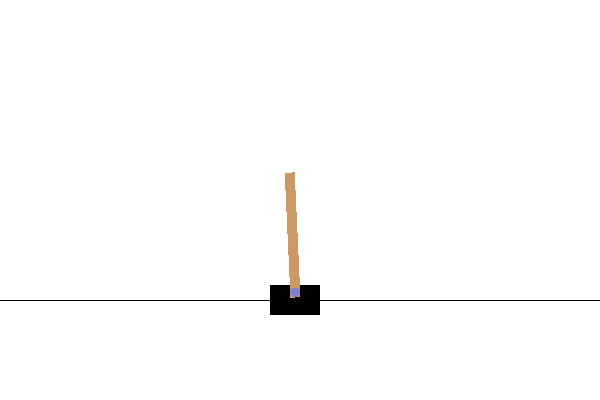

In [50]:
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

## Setup Checkpointer and PolicySaver

Now we are ready to use Checkpointer and PolicySaver.

### Checkpointer


In [51]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

### Policy Saver

In [52]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

### Train one iteration

In [53]:
print('Training one iteration....')
train_one_iteration()

Training one iteration....
iteration: 12 loss: 0.9983046650886536


### Save to checkpoint

In [54]:
train_checkpointer.save(global_step)

### Restore checkpoint

For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.

In [55]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Also save policy and export to a location

In [56]:
tf_policy_saver.save(policy_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.

Load the saved policy and check how it performs


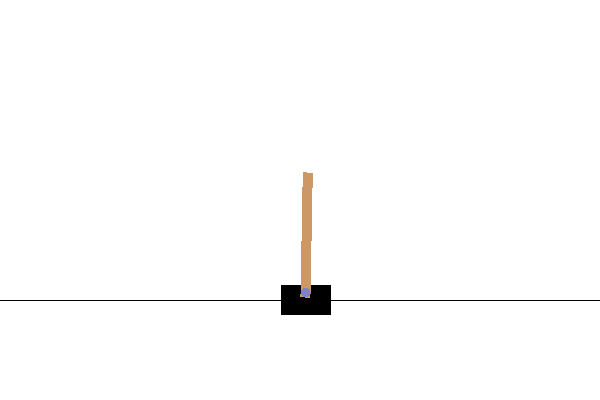

In [57]:
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

## SavedModelPyTFEagerPolicy

If we don't want to use TF policy, then we can also use the saved_model directly with the Python env through the use of `py_tf_eager_policy.SavedModelPyTFEagerPolicy`.

Note that this only works when eager mode is enabled.


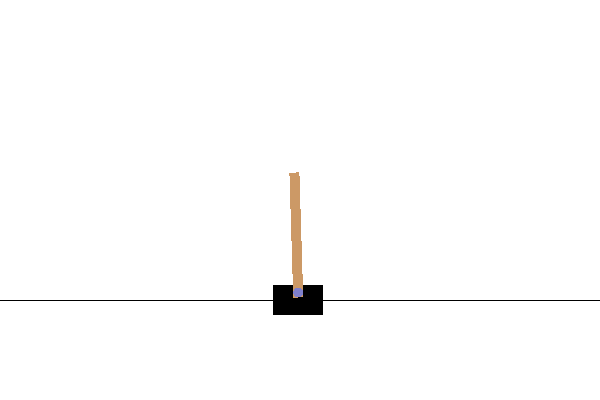

In [58]:
eager_py_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    policy_dir, eval_py_env.time_step_spec(), eval_py_env.action_spec())

# Note that we're passing eval_py_env not eval_env.
run_episodes_and_create_video(eager_py_policy, eval_py_env, eval_py_env)